# Practice multi-class classification

In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

numClasses =4
numFeatures = 2
random_seed = 42

X_blob, y_blob = make_blobs(
    n_samples =1000,
    n_features=numFeatures,
    centers = numClasses,
    cluster_std =1.5,
    random_state = random_seed
)
X_blob.shape , X_blob[:5]    

((1000, 2),
 array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]))

In [15]:
y_blob.shape , y_blob[:5]

((1000,), array([3, 2, 2, 1, 1]))

In [16]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# split  data 80 20
X_train,X_test,y_train,y_test = train_test_split(
    X_blob,
    y_blob,
    test_size =0.2,
    random_state = random_seed
)
    



(800, 200)

In [17]:
len(X_train),len(X_test)

(800, 200)

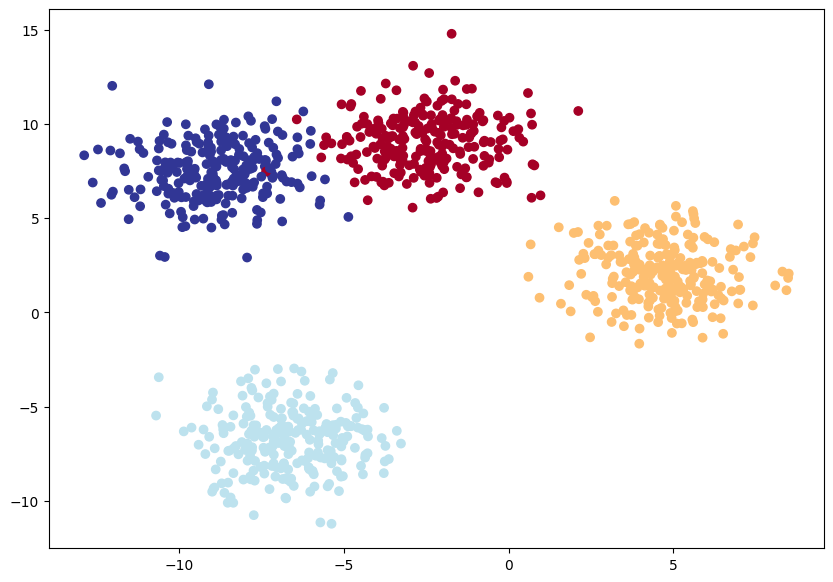

In [19]:
plt.figure(figsize =(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c = y_blob , cmap = plt.cm.RdYlBu)

In [20]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self,input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
             nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
             nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
        
model_0 = BlobModel(
    input_features = numFeatures,
    output_features = numClasses,
    hidden_units=8
).to(device)        

In [23]:
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr = 0.1)

In [25]:
model_0(X_train.to(device))[:5]

tensor([[-0.1117, -0.1350, -0.3496, -0.2098],
        [-0.8465, -0.8107, -0.2472, -0.5754],
        [-0.4987, -0.4196,  0.0318, -0.3164],
        [-0.3539, -0.3559, -0.1444, -0.1350],
        [-0.6342, -0.7205, -0.2285, -0.3568]], grad_fn=<SliceBackward0>)

In [28]:
model_0(X_train.to(device)).shape

torch.Size([800, 4])

In [51]:
# for multi class classification
# we use softmax function to 
# convert our raw data into  prediction probalities

y_logits = model_0(X_test.to(device))
y_preds_probs = torch.softmax(y_logits,dim=1)
y_logits[:5],y_preds_probs[:5],y_logits.dtype

(tensor([[-0.1380, -0.1715, -0.3301, -0.2500],
         [-0.6105, -0.7722, -0.1133, -0.2584],
         [-0.2953, -0.3405,  0.0110, -0.1777],
         [ 0.0640, -0.1214, -0.2706,  0.0094],
         [-0.8141, -0.7123, -0.2741, -0.6586]], grad_fn=<SliceBackward0>),
 tensor([[0.2713, 0.2623, 0.2239, 0.2425],
         [0.2034, 0.1730, 0.3344, 0.2892],
         [0.2253, 0.2153, 0.3060, 0.2534],
         [0.2863, 0.2378, 0.2048, 0.2710],
         [0.2003, 0.2218, 0.3438, 0.2341]], grad_fn=<SliceBackward0>),
 torch.float32)

# how to choose best dim for softmax?
| Shape Example                        | Meaning                        | Use `dim=` |
| ------------------------------------ | ------------------------------ | ---------- |
| `[batch_size, num_classes]`          | Standard classification        | `1`        |
| `[batch, class, height, width]`      | Segmentation (image per pixel) | `1`        |
| `[batch, sequence_len, num_classes]` | NLP / sequence classification  | `2`        |
| `[class]` or `[num_classes]`         | Just class scores              | `0`        |


In [34]:
# here we make predictions probabilites 
# so our class summations of 
# all classes probabilities must be 1
y_preds_probs[0].size(),torch.sum(y_preds_probs[0])

(torch.Size([4]), tensor(1.0000, grad_fn=<SumBackward0>))

In [37]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [41]:
torch.manual_seed(42)
loops = 1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [60]:
for loop in range(loops):
    model_0.train()
    y_logits = model_0(X_train)
    # print("y_logits type :",y_logits.dtype)
    # print("y_train type :",y_logits.dtype)
    y_preds_probs = torch.softmax(y_logits,dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits,y_train.long())
    acc =  accuracy_fn(y_train,y_preds_probs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_preds_probs = torch.softmax(test_logits,dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits,y_test.long())
        test_acc = accuracy_fn(y_test,test_preds_probs)

    if loop % 100 ==0 :
         print(f"Epoch: {loop} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    



Epoch: 0 | Loss: 0.02182, Acc: 99.50% | Test Loss: 0.01005, Test Acc: 99.50%
Epoch: 100 | Loss: 0.02164, Acc: 99.50% | Test Loss: 0.00987, Test Acc: 99.50%
Epoch: 200 | Loss: 0.02146, Acc: 99.50% | Test Loss: 0.00971, Test Acc: 99.50%
Epoch: 300 | Loss: 0.02129, Acc: 99.50% | Test Loss: 0.00954, Test Acc: 99.50%
Epoch: 400 | Loss: 0.02113, Acc: 99.50% | Test Loss: 0.00938, Test Acc: 99.50%
Epoch: 500 | Loss: 0.02097, Acc: 99.50% | Test Loss: 0.00923, Test Acc: 99.50%
Epoch: 600 | Loss: 0.02082, Acc: 99.50% | Test Loss: 0.00908, Test Acc: 99.50%
Epoch: 700 | Loss: 0.02067, Acc: 99.50% | Test Loss: 0.00893, Test Acc: 99.50%
Epoch: 800 | Loss: 0.02052, Acc: 99.50% | Test Loss: 0.00878, Test Acc: 99.50%
Epoch: 900 | Loss: 0.02038, Acc: 99.50% | Test Loss: 0.00864, Test Acc: 99.50%


In [58]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

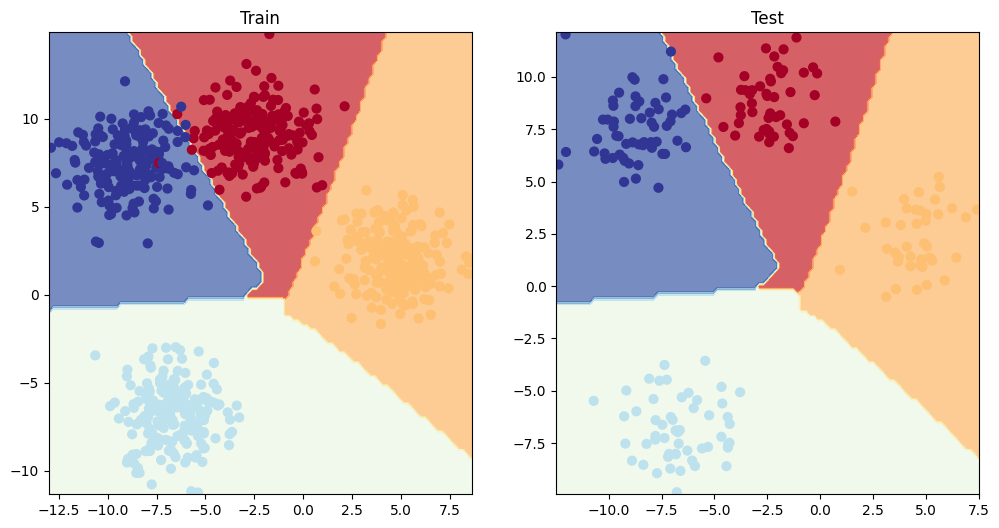

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

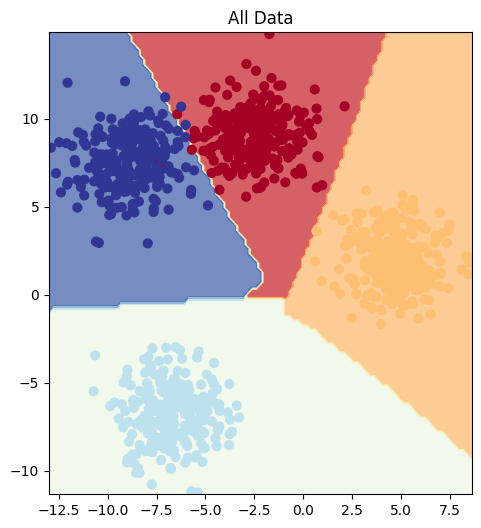

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("All Data")
plot_decision_boundary(model_0, X_blob, y_blob)